# JMeter results (.csv) file analysis notebook
- copy the results .csv file to the docker mounted volume which is the directory from where you started this container

- make sure we have column header name as the 1st rown in the below order _timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,Connect_

- transaction controller name have the workspace/tenant id suffixed as _<workspaceid/tenantid>

> *Dataframe is sensitive to whitespaces, make sure in the label and other places there are not leading/trailing whitespaces at all*


In [5]:
import pandas as pd
import seaborn.objects as so
import seaborn as sns

file_path = '/home/ubuntu/work/jmeter_disconnect_results_jmeter-result.csv'
df = pd.read_csv(file_path)

df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='ms')

# filter out only the transaction level data points
df_filtered = df[df.responseMessage.str.match('Number of samples in transaction.*',na=False)]

# label name have tenant/workspace as suffix, split the label column into 2 with a regex and 
# the new column will be added as workspace dimension
df_filtered[['label','workspace']] = df_filtered['label'].str.extract('(.*)_(.+)$',expand=True)

# generate a new column lat_perc_of_resp_time expressing latency as % of reponse time
df_filtered ['lat_perc_of_resp_time'] = 100*df_filtered['Latency']/df_filtered['elapsed']

# generate a new column conn_perc_of_resp_time expressing connect time as % of reponse time
df_filtered ['conn_perc_of_resp_time'] = 100*df_filtered['Connect']/df_filtered['elapsed']


/tmp/ipykernel_88/3035068857.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['label','workspace']] = df_filtered['label'].str.extract('(.*)_(.+)$',expand=True)
/tmp/ipykernel_88/3035068857.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['label','workspace']] = df_filtered['label'].str.extract('(.*)_(.+)$',expand=True)
/tmp/ipykernel_88/3035068857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

## Total test duration

In [6]:
df.reset_index().set_index('timeStamp',inplace=True)
print (df.timeStamp.iloc[-1] -df.timeStamp.iloc[0])

0 days 00:59:36.005000


## Elapsed/response time summary
breakup by workspace/tenantid

In [7]:
df_filtered.groupby('workspace')['elapsed'].describe ()

,count,mean,std,min,25%,50%,75%,max
workspace,,,,,,,,
9pjsrlzm0w9sahuv,264.0,1675.185606,2336.002443,33.0,480.75,1028.5,1734.25,18522.0
kh7boxulcctlz1km,243.0,1745.477366,2266.178396,32.0,497.50,1044.0,1934.50,18358.0
qatzlnh8da6hq62w,240.0,1691.083333,2259.305485,32.0,463.75,1075.5,1739.00,16832.0
qektw4wuknlptcvz,240.0,1789.083333,2460.693371,32.0,499.50,1103.5,2017.75,17951.0
wgxnz4qadljnuwvf,272.0,1658.849265,2250.250027,32.0,461.50,1037.0,1685.50,16804.0


## Downsampling elapsed, Latency, Connect column
5 sec interval with aggregation function max applied

<Axes: xlabel='timeStamp'>

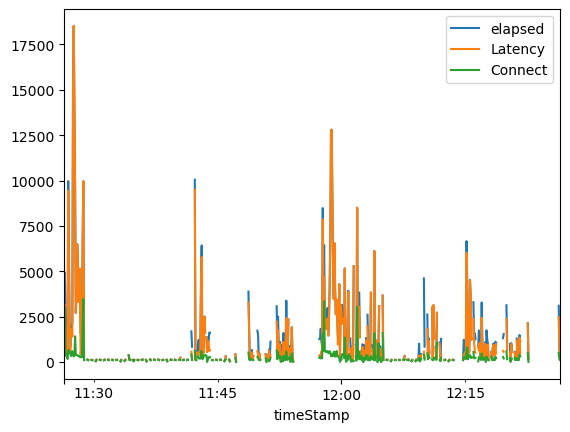

In [8]:
# convert the index to DatetimeIndex from RangeIndex for aiding with downsampling etc
df_downsample = df.copy()
df_downsample.set_index('timeStamp',inplace=True)
df_downsample = df_downsample[["elapsed","Latency","Connect"]].resample("5s").max()
df_downsample.plot()

## Individual _elapsed/response time_ plot per transaction (facet col=label) and grouped by workspace (color=workspace)

In [ ]:

(
    so.Plot(df_filtered, x="timeStamp", y="elapsed", color="workspace")
    .facet(col = 'label',wrap=9)
    .add(so.Line())
    .layout(size=(90, 15),engine="constrained")
)


## Individual _latency time_ plot per transaction (facet col=label) and grouped by workspace (color=workspace)

In [ ]:
(
    so.Plot(df_filtered, x="timeStamp", y="Latency", color="workspace")
    .facet(col = 'label',wrap=9)
    .add(so.Line())
    .layout(size=(90, 15),engine="constrained")
)

## Individual _Connect time_ plot per transaction (facet col=label) and grouped by workspace (color=workspace)

In [ ]:
(
    so.Plot(df_filtered, x="timeStamp", y="Connect", color="workspace")
    .facet(col = 'label',wrap=9)
    .add(so.Line())
    .layout(size=(90, 15),engine="constrained")
)

## Filter elapsed/response time > 5sec, plot transaction across workspace
Aggregation max/min/mean/count

In [10]:
p_table = pd.pivot_table( data=df_filtered, 
                        index=['label'], 
                        columns=['workspace'], 
                        values='elapsed',
                        aggfunc=['max','min', 'mean', 'count'],
                        fill_value="None")

#p_table
p_table[p_table["mean"] > 5000]

max  \
workspace                                          9pjsrlzm0w9sahuv   
label                                                                 
DMX_T01_Launch url                                              NaN   
DMX_T02_Enter username                                          NaN   
DMX_T03_Enter password and login                                NaN   
DMX_T04_AddServer_GotoRuntimeEnv                                NaN   
DMX_T04_SelectProduct                                           NaN   
DMX_T05_AddServer_TestServerConnection                          NaN   
DMX_T06_AddServer_SaveServer                                    NaN   
DMX_T07_AddSrcDataConn_GotoDataConnections                      NaN   
DMX_T08_AddOraDataConn_TestConnection                       18522.0   
DMX_T09_AddOraDataConn_SaveDCAndContinueToCatalog            6718.0   
DMX_T10_AddSrcDataConn_StartCatalog                             NaN   
DMX_T11_AddKafkaDataConn_GotoDataConnections                    NaN   
DMX_T12_AddKafkaDataConn_TestConnection                         NaN   
DMX_T13_AddKafkaDataConn_SaveDCAndContinueToCat...              NaN   
DMX_T14_AddKafkaDataConn_StartCatalog                           NaN   
DMX_T15_AddPipeWithExistMeta_GotoReplicationPip...              NaN   
DMX_T16_AddPipeWithExistMeta_ClickCreatePipelin...              NaN   
DMX_T17_AddPipeWithExistMeta_ProvideNameSelectR...              NaN   
DMX_T18_AddPipeWithExistMeta_ClickNextwithExist...              NaN   
DMX_T19_AddPipeWithExistMeta_SelectSchemaToDisp...              NaN   
DMX_T20_AddPipeWithExistMeta_SelectTableToDispl...              NaN   
DMX_T21_AddPipeWithExistMeta_Select50TablesAndC...              NaN   
DMX_T24_AddPipeWithExistMeta_ClickNextToMapping...              NaN   
DMX_T25_SeedPipeline_ClickValidate                              NaN   
DMX_T26_SeedPipeline_ClickFinish                                NaN   
DMX_T27_StartPipeline_GotoReplicationPipelines                  NaN   
DMX_T28_StartPipeline_StopPipeline                              NaN   
DMX_T29_StartPipeline_ApplyConfigChanges                        NaN   
DMX_T30_StartPipeline_StartPipeline                             NaN   
DMX_T31_ViewStatusAlert_GotoReplicationPipelines                NaN   
DMX_T32_ViewStatusAlert_RefreshPipelineDetails                  NaN   
DMX_T32_signout                                                 NaN   
DMX_T33_ViewStatusAlert_RefreshAlerts                           NaN   
Module_getKafkaTopicsAPI                                        NaN   
Module_monitoringAPI                                            NaN   
Module_updateDataflowsAPI                                       NaN   
Module_validate-commitStatusAPI                                 NaN   
Module_validateAPI                                              NaN   

                                                                     \
workspace                                          kh7boxulcctlz1km   
label                                                                 
DMX_T01_Launch url                                              NaN   
DMX_T02_Enter username                                          NaN   
DMX_T03_Enter password and login                                NaN   
DMX_T04_AddServer_GotoRuntimeEnv                                NaN   
DMX_T04_SelectProduct                                           NaN   
DMX_T05_AddServer_TestServerConnection                          NaN   
DMX_T06_AddServer_SaveServer                                    NaN   
DMX_T07_AddSrcDataConn_GotoDataConnections                      NaN   
DMX_T08_AddOraDataConn_TestConnection                       18358.0   
DMX_T09_AddOraDataConn_SaveDCAndContinueToCatalog               NaN   
DMX_T10_AddSrcDataConn_StartCatalog                             NaN   
DMX_T11_AddKafkaDataConn_GotoDataConnections                    NaN   
DMX_T12_AddKafkaDataConn_TestConnection                         NaN   
DMX_T13_AddKafka

## Max elapsed/response time and threadcount summary across workspaces
Aggregation max for both elapsed/response time and threadcount/allThreads
Filter only transactions with response time > 5sec
Ref: https://datagy.io/python-pivot-tables/

In [11]:
p_table = pd.pivot_table( data=df_filtered, 
                        index=['label'], 
                        values=['elapsed','allThreads'],
                        aggfunc={'elapsed':'max','allThreads':'max'},
                        fill_value="None")

#p_table
print(p_table[p_table["elapsed"] > 5000])

                                                    allThreads  elapsed
label                                                                  
DMX_T03_Enter password and login                            50    10045
DMX_T06_AddServer_SaveServer                                50     5959
DMX_T08_AddOraDataConn_TestConnection                       50    18522
DMX_T09_AddOraDataConn_SaveDCAndContinueToCatalog           50     6946
DMX_T10_AddSrcDataConn_StartCatalog                         50     5138
DMX_T12_AddKafkaDataConn_TestConnection                     50     9160
DMX_T20_AddPipeWithExistMeta_SelectTableToDispl...          50     5278
DMX_T24_AddPipeWithExistMeta_ClickNextToMapping...          50     9958


## Regression/trend analysis for elapsed/response time
Original data resampled to 5 sec interval 

In [ ]:
import numpy as np

df_fit = df_filtered.copy()

# Convert 'timeStamp' column to datetime
df_fit['timeStamp'] = pd.to_datetime(df_fit['timeStamp'])

# Convert datetime to numeric representation (Unix epoch time in this case)
df_fit['date_ordinal'] = df_fit['timeStamp'].astype(int) // 10**9

# Fit a linear regression line using 'x_numeric' and 'y' columns and get the slope
coefficients = np.polyfit(df_fit['date_ordinal'], df_fit['elapsed'], 1)
slope = coefficients[0]

# Optional: You can convert the slope back to a human-readable format
# Assuming the slope is in units per second (m/s in this case)
slope_human_readable = slope * (10**9)

print("Slope:", slope)
print("Slope (human-readable):", slope_human_readable)


In [ ]:
## Regression/trend analysis for elapsed/response time (using sklearn package)
Original data resampled to 5 sec interval 

In [ ]:
from sklearn import linear_model
import datetime as dt

df_reg = df_filtered.copy()

df_reg = pd.DataFrame(df_reg, columns=['timeStamp', 'elapsed'])

df_reg['date_ordinal'] = df_fit['timeStamp'].astype(int) // 10**9

reg = linear_model.LinearRegression()
reg.fit(df_reg['date_ordinal'].values.reshape(-1, 1), df_reg['elapsed'].values)
reg.coef_


In [ ]:
## Plot elapsed/response time trend graph
_It takes some time to load all the individual plots_

In [ ]:
# Using Hue to Add an Additional Variable to Seaborn lmplot()
import matplotlib.pyplot as plt
df_mat_plot = df_filtered.copy()

df_mat_plot = pd.DataFrame(df_mat_plot, columns=['timeStamp', 'elapsed','label', 'workspace'])

df_mat_plot['date_ordinal'] = df_mat_plot['timeStamp'].astype(int) // 10**9

#sns.lmplot(data=df_mat_plot, x='date_ordinal', y='elapsed', hue='workspace')

#sns.regplot(data=df_mat_plot, x='date_ordinal', y='elapsed')

sns.lmplot(data=df_mat_plot, x='date_ordinal', y='elapsed', col='workspace', row='label')

plt.show()